_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Student names: *FILL IN YOUR NAMES HERE*

# Coding Lab 2

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [33]:
from __future__ import annotations
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-05-02 08:43:45CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.12.0

sklearn: 1.2.2

scipy     : 1.10.1
matplotlib: 3.7.1
numpy     : 1.24.2

Watermark: 2.3.1



In [34]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [35]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [36]:
def sample_data(
    N: int, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Generate N samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    N: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """

    # insert your code here

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------
    # return labels, x
    n_clusters = len(m)
    samples = np.zeros((N, 2))
    labels = np.zeros(N)
    for i in range(N):
        # Choose a cluster at random
        k = np.random.choice(n_clusters, p=p)
        labels[i] = k
        # Draw a sample from the chosen cluster
        sample = np.random.multivariate_normal(m[k], S[k])
        samples[i] = sample

    return labels, samples

In [37]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

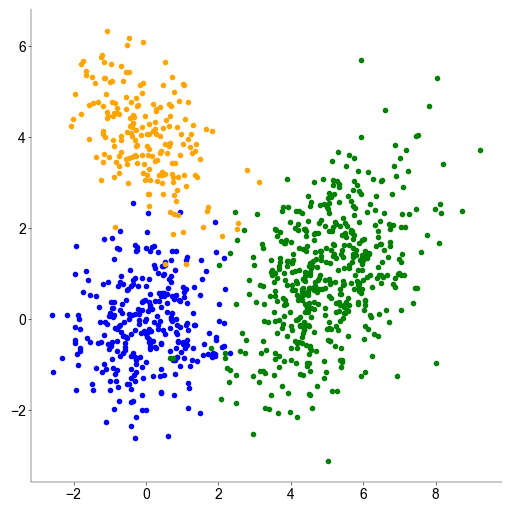

In [38]:
# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------
colors = ["blue", "green", "orange"]
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(len(np.unique(labels))):
    ax.scatter(x=x[labels == i, 0], y=x[labels == i, 1], color=colors[i])
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [7]:
def whiten(X):
    # compute the covariance matrix of X
    cov = np.cov(X.T)

    # compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # compute the diagonal matrix of eigenvalues
    D = np.diag(eigenvalues)

    # compute the square root of the diagonal matrix
    D_sqrt = np.sqrt(D)

    # compute the inverse of the square root of the diagonal matrix
    D_sqrt_inv = np.linalg.inv(D_sqrt)

    # compute the whitening matrix
    whitening_matrix = np.dot(D_sqrt_inv, eigenvectors.T)

    # whiten the data
    X_white = np.dot(X, whitening_matrix.T)

    return X_white, np.linalg.inv(whitening_matrix)

In [43]:
def fit_mog(
    x: np.ndarray, k: int, niters: int = 10, random_seed: int = 2046
) -> tuple[np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    k: int
        Number of clusters

    niters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """

    # fill in your code here

    np.random.seed(random_seed)

    # -----------
    # init (1 pt)
    # -----------

    n_samples, n_dim = x.shape

    # m = np.random.randn(k, n_dim)
    # S = np.array([np.eye(n_dim) for _ in range(k)])
    # compute mean and covariance of the data

    # whiten the data
    # x_white, W_inv = whiten(x)

    # initialize the means of the Gaussians to be randomly sampled from the data
    m = np.random.permutation(x)[:k]

    S = np.array([np.eye(n_dim) for _ in range(k)])

    # initialize the weights of the Gaussians to be uniform
    p = np.ones(k) / k

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------

    for step in range(niters):
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`
        r = np.zeros((n_samples, k))
        for i in range(k):
            r[:, i] = p[i] * sp.stats.multivariate_normal.pdf(x, mean=m[i], cov=S[i])

        r /= r.sum(axis=1, keepdims=True)  # Normalize

        # M step
        # Estimate new `m`, `S` and `p`
        Nk = r.sum(axis=0)
        p = Nk / n_samples
        m = (r.T @ x) / Nk[:, None]
        for i in range(k):
            diff = x - m[i]
            S[i] = (r[:, i, None, None] * diff[:, None] * diff[:, :, None]).sum(
                axis=0
            ) / Nk[i]

        # Assign labels
        labels = np.argmax(r, axis=1)

    # ------------------------
    # rescale mean and cov
    # m = m @ W_inv
    # S = np.array([W_inv @ S[i] @ W_inv.T for i in range(k)])

    return labels, m, S, p

Run Mixture of Gaussian on toy data

In [46]:
mog_labels, m, S, p = fit_mog(x, k=3, random_seed=0, niters=20)

Plot toy data with cluster assignments and compare to original labels

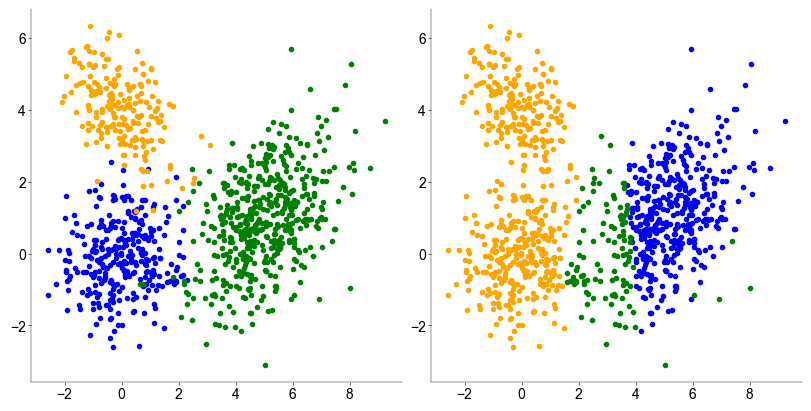

In [47]:
mosaic = [["True", "MoG"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 4), layout="constrained")

# -----------------
# Add plot (0.5 pts)
# -----------------

colors = ["blue", "green", "orange"]
for i in range(len(np.unique(mog_labels))):
    ax["MoG"].scatter(x=x[mog_labels == i, 0], y=x[mog_labels == i, 1], color=colors[i])
    ax["True"].scatter(x=x[labels == i, 0], y=x[labels == i, 1], color=colors[i])
plt.show()

Note, that the two plots differ. This is mostly because the EM runs only for 10 iterations. Setting niter to a higher integer two cells above yields more accurate results.

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 3 pts*



In [48]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    k, n_dims = m.shape
    N, _ = x.shape

    # Compute the log-likelihood (Formula from the lecture)
    LL = np.sum(
        np.log(
            np.sum(
                np.array(
                    [
                        p[i] * sp.stats.multivariate_normal.pdf(x, mean=m[i], cov=S[i])
                        for i in range(k)
                    ]
                ),
                axis=0,
            )
        )
    )
    P = k * (
        n_dims + np.sum(range(n_dims)) + 1
    )  # first term: means, second term: (symmetric) covariance matrices, third term: responsibilities

    # Compute the BIC
    bic = -2 * LL + P * np.log(N)

    return bic, LL

In [49]:
mog_bic(x, m=m, S=S, p=p)

(8272.205887828926, -4094.6564122405707)

In [50]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (0.5 pts) and plot the result (0.5 pts)
# ---------------------------------------------------------------------------------------------------

K = range(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here

for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, m, S, p = fit_mog(x, k=k, random_seed=j)
        bic, ll = mog_bic(x, m=m, S=S, p=p)
        BIC[j, i] = bic
        LL[j, i] = ll

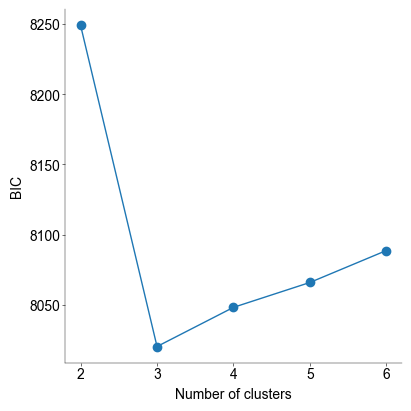

In [51]:
fig, ax = plt.subplots(figsize=(4, 4))


# plot BIC
ax.plot(K, BIC.min(axis=0), marker="o")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
plt.show()

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [52]:
# ------------------------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (include plot) (1 pt)
# ------------------------------------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# we have loaded the features in to the variable 'b'
print(b.shape)

# run mog and BIC multiple times here (same as above)

for i, k in enumerate(K):
    print(f"Number of Clusters:{k}")
    for j in range(num_seeds):
        mog_labels, m, S, p = fit_mog(b, k=k, random_seed=j)
        bic, ll = mog_bic(b, m=m, S=S, p=p)
        BIC[j, i] = bic
        LL[j, i] = ll

(19546, 12)
Number of Clusters:2


/var/folders/zk/bzxr7lm121n4cyppry4v80mc0000gn/T/ipykernel_78449/4085131024.py:75: RuntimeWarning: invalid value encountered in divide
  r /= r.sum(axis=1, keepdims=True)  # Normalize


ValueError: array must not contain infs or NaNs

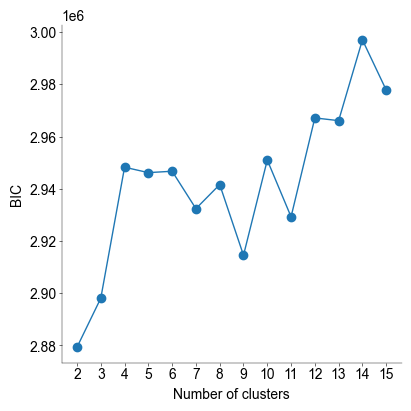

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot BIC
ax.plot(K, BIC.min(axis=0), marker="o")
ax.set_xlabel("Number of clusters")
ax.set_xticks(K)
ax.set_ylabel("BIC")
plt.show()

Refit model with lowest BIC and plot data points

In [31]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed)

lowest BIC: # cluster = 2


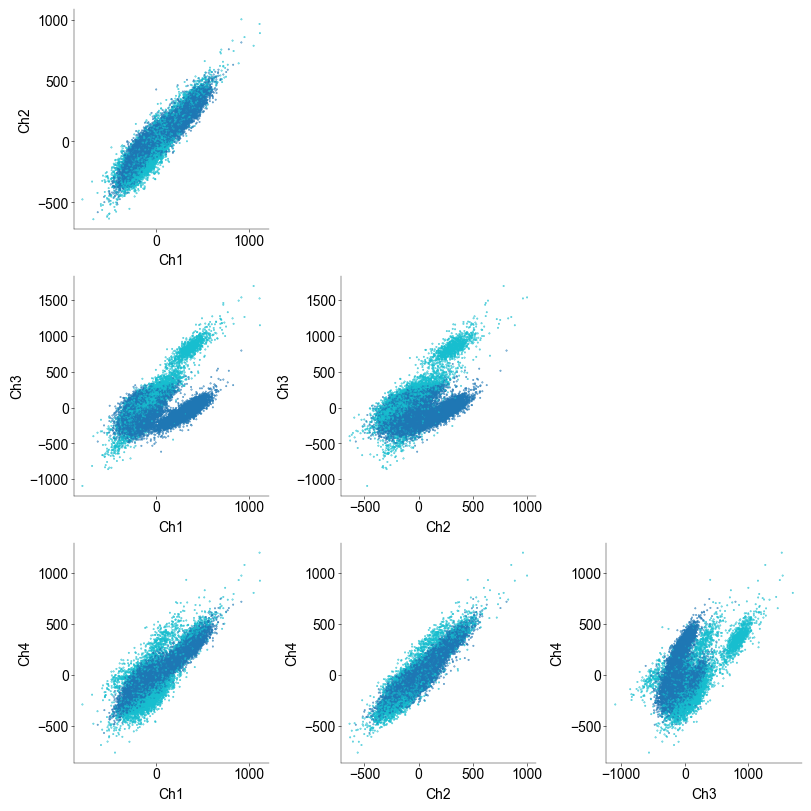

In [32]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------


mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8), layout="constrained")

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    y, x = m.split(" vs ")
    ax[m].scatter(b[:, i[x]], b[:, i[y]], c=a, s=0.5)
    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)
plt.show()

### Task 5: Cluster separation

Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.

*Grading: 4 pts*


In [19]:
def separation(
    b: np.ndarray,
    m: np.ndarray,
    S: np.ndarray,
    p: np.ndarray,
    assignment: np.ndarray,
    nbins: int = 50,
):
    """Calculate cluster separation by LDA.

    proj, bins = separation(b, m, S, p, assignment)
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---

    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.

    m: np.array, (n_clusters, n_features)
        Means.

    S: np.array, (n_clusters, n_features, n_features)
        Covariance.

    p: np.array, (n_clusters, )
        Cluster weight.

    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    nbins: int
        Number of bins in a lda histogram.


    Returns
    -------

    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular

    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    """

    # insert your code here

    # ---------------------------------------------------------------------
    # compute the optimal separating axes for each pair of clusters (2 pts)
    # ---------------------------------------------------------------------

    

    # -------------------------------------------
    # normalise according to first cluster (1 pt)
    # -------------------------------------------

    # --------------------------------------
    # plot histograms on optimal axis (1 pt)
    # --------------------------------------

    return proj, bins

In [20]:
# proj, bins = separation(b, m, S, p, a)